# Import Necessary Libraries

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import os



# Define Utility Functions for Noise Generation, Label Encoding, and Image Display


In [ ]:

def generate_noise(batch_size, noise_dim, device='cpu'):
    """
    Generates random noise vectors for the generator input.
    """
    return torch.randn(batch_size, noise_dim, device=device)

def one_hot_encode_labels(labels, num_classes):
    """
    Converts label indices into one-hot encoded vectors.
    """
    return F.one_hot(labels, num_classes)

def combine_vectors(x, y):
    """
    Combines two vectors by concatenating them along the specified dimension.
    """
    return torch.cat((x.float(), y.float()), dim=1)

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    """
    Displays a batch of images in a grid format.
    """
    image_tensor = (image_tensor + 1) / 2  # Normalize to [0, 1]
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze(), cmap="gray")
    if show:
        plt.show()


# Define Generator Architecture for Fashion MNIST GAN


In [ ]:
class FashionGenerator(nn.Module):
    def __init__(self, input_dim=74, image_channels=1, hidden_dim=64):
        super(FashionGenerator, self).__init__()
        self.input_dim = input_dim
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, image_channels, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)


# Define Discriminator Architecture for Fashion MNIST GAN


In [ ]:
class FashionDiscriminator(nn.Module):
    def __init__(self, image_channels=1, hidden_dim=64):
        super(FashionDiscriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(image_channels + 10, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)


# Load Fashion MNIST Dataset and Define DataLoader


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 128

fashion_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
data_loader = DataLoader(fashion_dataset, batch_size=batch_size, shuffle=True)


# Initialize Generator, Discriminator, and Optimizers


In [ ]:
latent_dim = 64
num_classes = 10
learning_rate = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = FashionGenerator(input_dim=latent_dim + num_classes).to(device)
discriminator = FashionDiscriminator().to(device)

gen_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))


# Train the GAN Model or Generate Images Based on User Input


Enter 'train' to train the model or 'generate' to generate images: generate
Enter the epoch number for the saved generator weights (e.g., '10', '20', '30', etc.): 10


<ipython-input-18-b8c0d40ea925>:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(weight_file, map_location=device))


Enter the number corresponding to the object you want to generate:
0: T-shirt/top, 1: Trouser, 2: Pullover, 3: Dress, 4: Coat
5: Sandal, 6: Shirt, 7: Sneaker, 8: Bag, 9: Ankle boot
Enter a number between 0 and 9: 7
Generated Images for class 7:


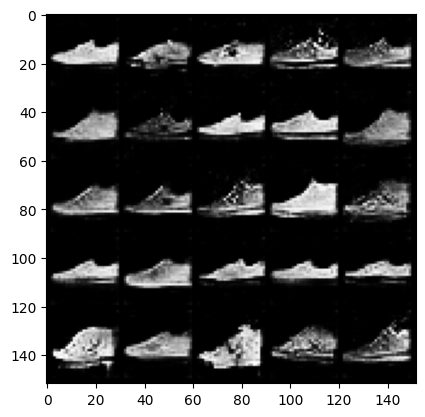

In [ ]:
action = input("Enter 'train' to train the model or 'generate' to generate images: ").strip().lower()

if action == 'train':
    # Train the GAN
    epochs = 50
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        for real, labels in tqdm(data_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            cur_batch_size = len(real)
            real = real.to(device)
            labels = labels.to(device)

            # Create one-hot labels
            one_hot_labels = one_hot_encode_labels(labels, num_classes).to(device)
            image_one_hot_labels = one_hot_labels[:, :, None, None]
            image_one_hot_labels = image_one_hot_labels.repeat(1, 1, 28, 28)

            ### Update Discriminator ###
            disc_optimizer.zero_grad()

            # Generate fake images
            noise = generate_noise(cur_batch_size, latent_dim, device=device)
            noise_and_labels = combine_vectors(noise, one_hot_labels)
            fake_images = generator(noise_and_labels)

            # Discriminator on real and fake images
            fake_image_and_labels = combine_vectors(fake_images.detach(), image_one_hot_labels)
            real_image_and_labels = combine_vectors(real, image_one_hot_labels)

            # Loss calculations
            real_output = discriminator(real_image_and_labels)
            fake_output = discriminator(fake_image_and_labels)
            real_loss = criterion(real_output, torch.ones_like(real_output))
            fake_loss = criterion(fake_output, torch.zeros_like(fake_output))
            disc_loss = (real_loss + fake_loss) / 2
            disc_loss.backward(retain_graph=True)
            disc_optimizer.step()

            ### Update Generator ###
            gen_optimizer.zero_grad()

            # Get discriminator feedback on fake images
            fake_image_and_labels = combine_vectors(fake_images, image_one_hot_labels)
            fake_output = discriminator(fake_image_and_labels)
            gen_loss = criterion(fake_output, torch.ones_like(fake_output))
            gen_loss.backward()
            gen_optimizer.step()

        # Print losses and display images every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Discriminator Loss: {disc_loss.item():.4f} Generator Loss: {gen_loss.item():.4f}")

            # Show real and fake images
            print("Real Images:")
            show_tensor_images(real)
            print("Fake Images:")
            show_tensor_images(fake_images)

            # Save model weights
            torch.save(generator.state_dict(), f'fashion_generator_epoch_{epoch+1}.pth')
            torch.save(discriminator.state_dict(), f'fashion_discriminator_epoch_{epoch+1}.pth')
            print(f"Model weights saved for epoch {epoch+1}.")

elif action == 'generate':
    # Generate images
    epoch = input("Enter the epoch number for the saved generator weights (e.g., '10', '20', '30', etc.): ").strip()
    weight_file = f'fashion_generator_epoch_{epoch}.pth'

    if os.path.exists(weight_file):
        generator.load_state_dict(torch.load(weight_file, map_location=device))
        generator.eval()

        # Ask the user to input which object/class they want to generate
        print("Enter the number corresponding to the object you want to generate:")
        print("0: T-shirt/top, 1: Trouser, 2: Pullover, 3: Dress, 4: Coat")
        print("5: Sandal, 6: Shirt, 7: Sneaker, 8: Bag, 9: Ankle boot")

        class_number = int(input("Enter a number between 0 and 9: ").strip())
        if class_number < 0 or class_number >= num_classes:
            print("Invalid class number. Please enter a number between 0 and 9.")
        else:
            # Generate images for the selected class
            noise = generate_noise(25, latent_dim, device=device)
            labels = torch.full((25,), class_number, device=device, dtype=torch.long)
            one_hot_labels = one_hot_encode_labels(labels, num_classes).to(device)
            noise_and_labels = combine_vectors(noise, one_hot_labels)
            fake_images = generator(noise_and_labels)

            # Show generated images
            print(f"Generated Images for class {class_number}:")
            show_tensor_images(fake_images)
    else:
        print(f"Weight file '{weight_file}' not found. Please train the model first.")
else:
    print("Invalid input. Please enter 'train' or 'generate'.")
